## Batch Evaluation
Set the folder parameter. Get an anaysis about all included batch evals

In [87]:
# import
import seaborn as sns
import numpy as np
import pandas as pd
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
import json
import os
import pathlib

#set path to folder
folder = "../../../eval-results/_server-results/test2"
net_analysis = "../../../eval-results/_server-results/net-BP-birth/net.eval" 

In [80]:
#fetch data 
dir_list = next(os.walk(folder))[1]
dfs = []
#merge all 
for subfolder in dir_list:
    print(subfolder)
    evalFile = folder +"/" + subfolder +"/aggResults.eval"
    confFile = folder +"/" + subfolder +"/config.log"
    if os.path.exists(evalFile):
        df = pd.read_csv(evalFile ,encoding="ISO-8859-1", skipinitialspace=True)
        with open(confFile) as json_file:
            conf = json.load(json_file)
        #add config information to dataframe 
        df['matcher'] = conf['matcher']['ilp'] + " - " + conf['matcher']['profile'] +" - " + str(conf['matcher']['word-sim']) + " - sim-weight=" + str(conf['matcher']['sim-weight']) + " - match-postprocessing=" + str(conf['matcher']['postprocessing-thresh']) 
        df['matcher_wo_weight'] = conf['matcher']['ilp'] + " - " + conf['matcher']['profile'] +" - " + str(conf['matcher']['word-sim']) + " - match-postprocessing=" + str(conf['matcher']['postprocessing-thresh']) 
        df['complex-matches'] = conf['matcher']['complex matches']
        df['profile'] = conf['matcher']['profile']
        df['ilp'] =  conf['matcher']['ilp']
        df['word-sim'] =  conf['matcher']['word-sim']
        df['sim-weight'] = conf['matcher']['sim-weight']
        df['matcher-postprocessing-threshold'] = conf['matcher']['postprocessing-thresh']
        #df['eval-postprocessing-threshold'] = conf['evaluation']['postprocessing-thresh']
        
        df.set_index(['Name','matcher'])
        dfs.append(df)
        
df_combined = pd.concat(dfs)

#convert time
df_combined['OVERALL TIME'] = df_combined['OVERALL TIME'].map(lambda x: x / 1000000000.)
df_combined['BP TIME'] = df_combined['BP TIME'].map(lambda x: x / 1000000000.)
df_combined['LABEL-SIM TIME'] = df_combined['LABEL-SIM TIME'].map(lambda x: x / 1000000000.)
df_combined['LP TIME'] = df_combined['LP TIME'].map(lambda x: x / 1000000000.)

#extend with net information stored in net_analysis
df_nets = pd.read_csv(net_analysis ,encoding="ISO-8859-1", skipinitialspace=True)
#df_nets.set_index('Name')

def net1adder(row):
    #get net names
    if row['Name'] != "Aggregated (MICRO)" and row['Name'] != "Aggregated (MACRO)":
        return row['Name'].split('-')[0].replace(".pnml","")
    else:
        return 0
def net2adder(row):        
    if row['Name'] != "Aggregated (MICRO)" and row['Name'] != "Aggregated (MACRO)":
        return row['Name'].split('-')[1].split('.')[0].replace(".pnml","")
    else: 
        return 0
def net1NonTaus(row):
    if row['Name'] != "Aggregated (MICRO)" and row['Name'] != "Aggregated (MACRO)":
        return df_nets.at[row['net1'],'nNonSilentTransitions'] 
    else:
        return 0
def net2NonTaus(row):
    if row['Name'] != "Aggregated (MICRO)" and row['Name'] != "Aggregated (MACRO)":
        return df_nets.at[row['net2'],'nNonSilentTransitions'] 
    else:
        return 0
def sumNonTaus(row):    
    if row['Name'] != "Aggregated (MICRO)" and row['Name'] != "Aggregated (MACRO)":
        return row['net1NonTaus'] + row['net2NonTaus']
    else:
        return 0
    
df_combined['net1'] = df_combined.apply(lambda row: net1adder(row), axis=1)
df_combined['net2'] = df_combined.apply(lambda row: net2adder(row), axis=1)
df_combined['net1NonTaus'] = df_combined.apply(lambda row: net1NonTaus(row), axis=1)
df_combined['net2NonTaus'] = df_combined.apply(lambda row: net2NonTaus(row), axis=1)
df_combined['sumNonTaus'] = df_combined.apply(lambda row: sumNonTaus(row), axis=1)

df_combined[:10]

batch-birth-BINARY-2019-11-21-16-02-59-245
batch-birth-BINARY-2019-11-21-16-02-59-289
batch-birth-BINARY-2019-11-21-16-03-00-393
batch-birth-BINARY-2019-11-21-16-02-59-596
batch-birth-BINARY-2019-11-21-16-02-59-199


,Name,TP,FP,FN,PRECISION,RECALL,FSCORE,OVERALL TIME,LP TIME,LABEL-SIM TIME,...,profile,ilp,word-sim,sim-weight,matcher-postprocessing-threshold,net1,net2,net1NonTaus,net2NonTaus,sumNonTaus
0,Aggregated (MACRO),358,2860,225,0.190134,0.611471,0.249619,22.901797,4.947980,17.507270,...,BP,RELAXED3,LEVENSHTEIN_LIN_MAX,0.4,0.0,0,0,0,0,0
1,Aggregated (MICRO),358,2860,225,0.111249,0.614065,0.188371,22.901797,4.947980,17.507270,...,BP,RELAXED3,LEVENSHTEIN_LIN_MAX,0.4,0.0,0,0,0,0,0
2,birthCertificate_p34.pnml-birthCertificate_p24...,3,21,3,0.125000,0.500000,0.200000,3.252635,1.332224,1.626830,...,BP,RELAXED3,LEVENSHTEIN_LIN_MAX,0.4,0.0,birthCertificate_p34,birthCertificate_p246,9,20,29
3,birthCertificate_p34.pnml-birthCertificate_p25...,6,53,1,0.101695,0.857143,0.181818,2.543919,0.937527,1.178994,...,BP,RELAXED3,LEVENSHTEIN_LIN_MAX,0.4,0.0,birthCertificate_p34,birthCertificate_p250,9,22,31
4,birthCertificate_p34.pnml-birthCertificate_p24...,5,30,3,0.142857,0.625000,0.232558,2.908720,1.465707,1.226686,...,BP,RELAXED3,LEVENSHTEIN_LIN_MAX,0.4,0.0,birthCertificate_p34,birthCertificate_p248,9,23,32
5,birthCertificate_p34.pnml-birthCertificate_p24...,2,14,6,0.125000,0.250000,0.166667,2.016136,0.560802,1.153227,...,BP,RELAXED3,LEVENSHTEIN_LIN_MAX,0.4,0.0,birthCertificate_p34,birthCertificate_p247,9,25,34
6,birthCertificate_p34.pnml-birthCertificate_p24...,3,28,2,0.096774,0.600000,0.166667,2.926495,0.487133,2.354087,...,BP,RELAXED3,LEVENSHTEIN_LIN_MAX,0.4,0.0,birthCertificate_p34,birthCertificate_p249,9,20,29
7,birthCertificate_p31.pnml-birthCertificate_p34...,21,31,5,0.403846,0.807692,0.538462,5.083660,0.303658,4.370327,...,BP,RELAXED3,LEVENSHTEIN_LIN_MAX,0.4,0.0,birthCertificate_p31,birthCertificate_p34,19,9,28
8,birthCertificate_p31.pnml-birthCertificate_p32...,9,60,7,0.130435,0.562500,0.211765,20.159170,1.291058,18.396166,...,BP,RELAXED3,LEVENSHTEIN_LIN_MAX,0.4,0.0,birthCertificate_p31,birthCertificate_p32,19,14,33
9,birthCertificate_p31.pnml-birthCertificate_p33...,7,111,3,0.059322,0.700000,0.109375,42.674467,4.078234,37.666763,...,BP,RELAXED3,LEVENSHTEIN_LIN_MAX,0.4,0.0,birthCertificate_p31,birthCertificate_p33,19,22,41


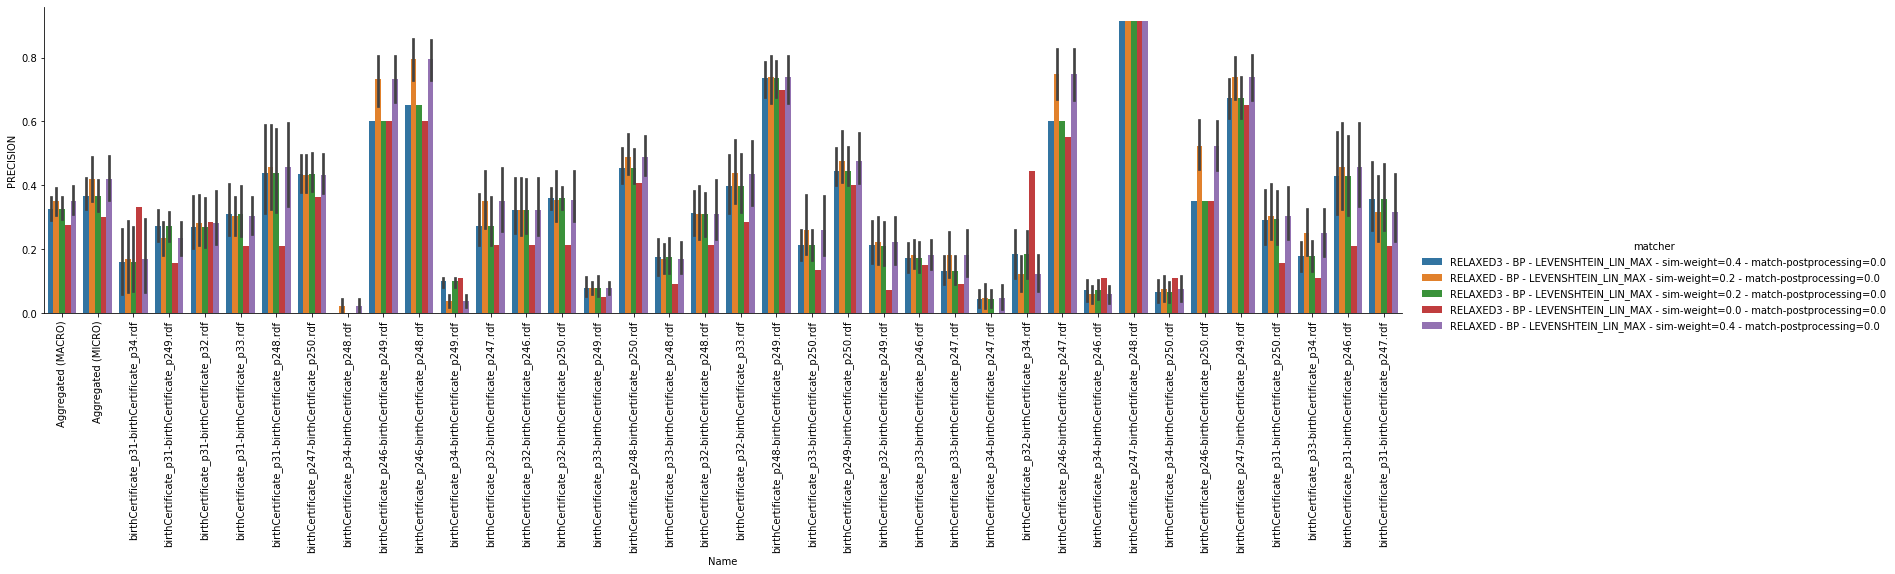

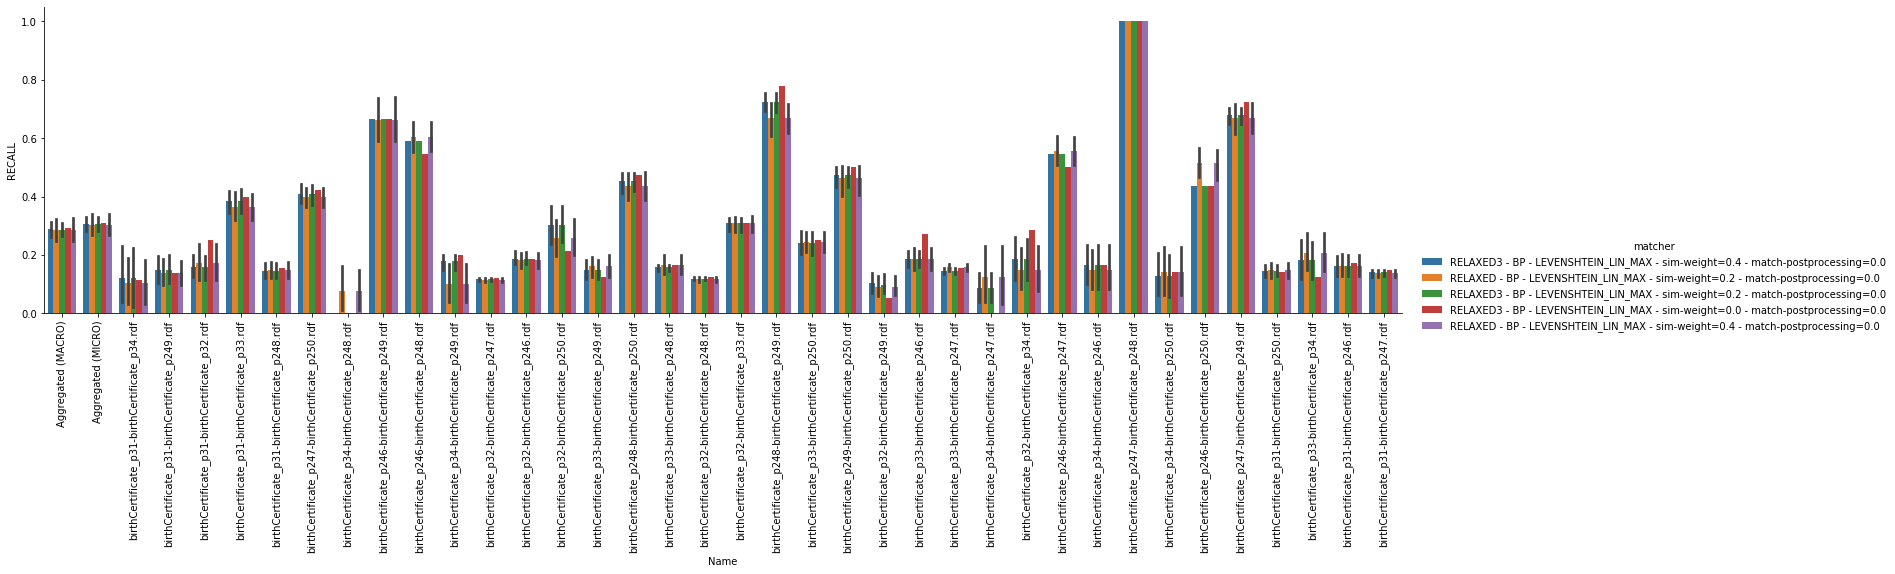

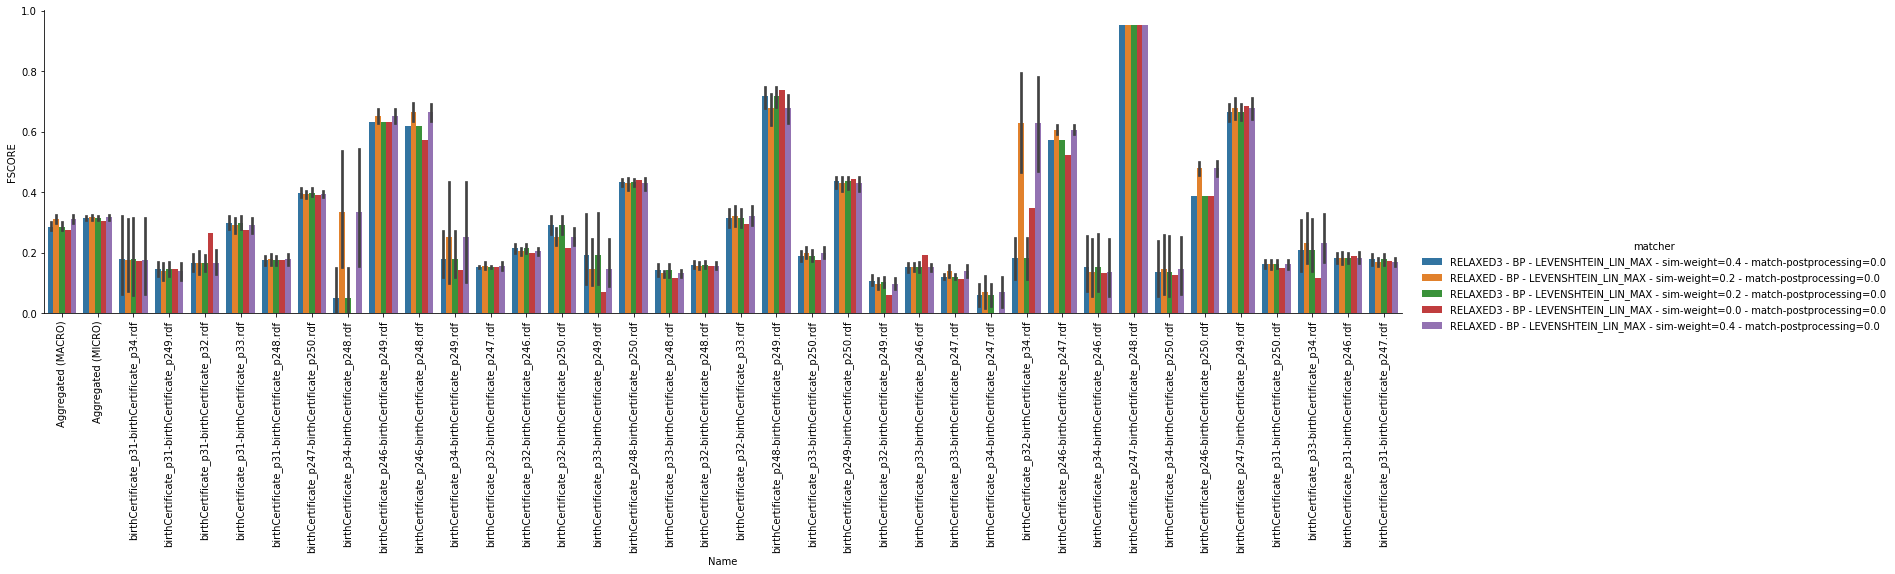

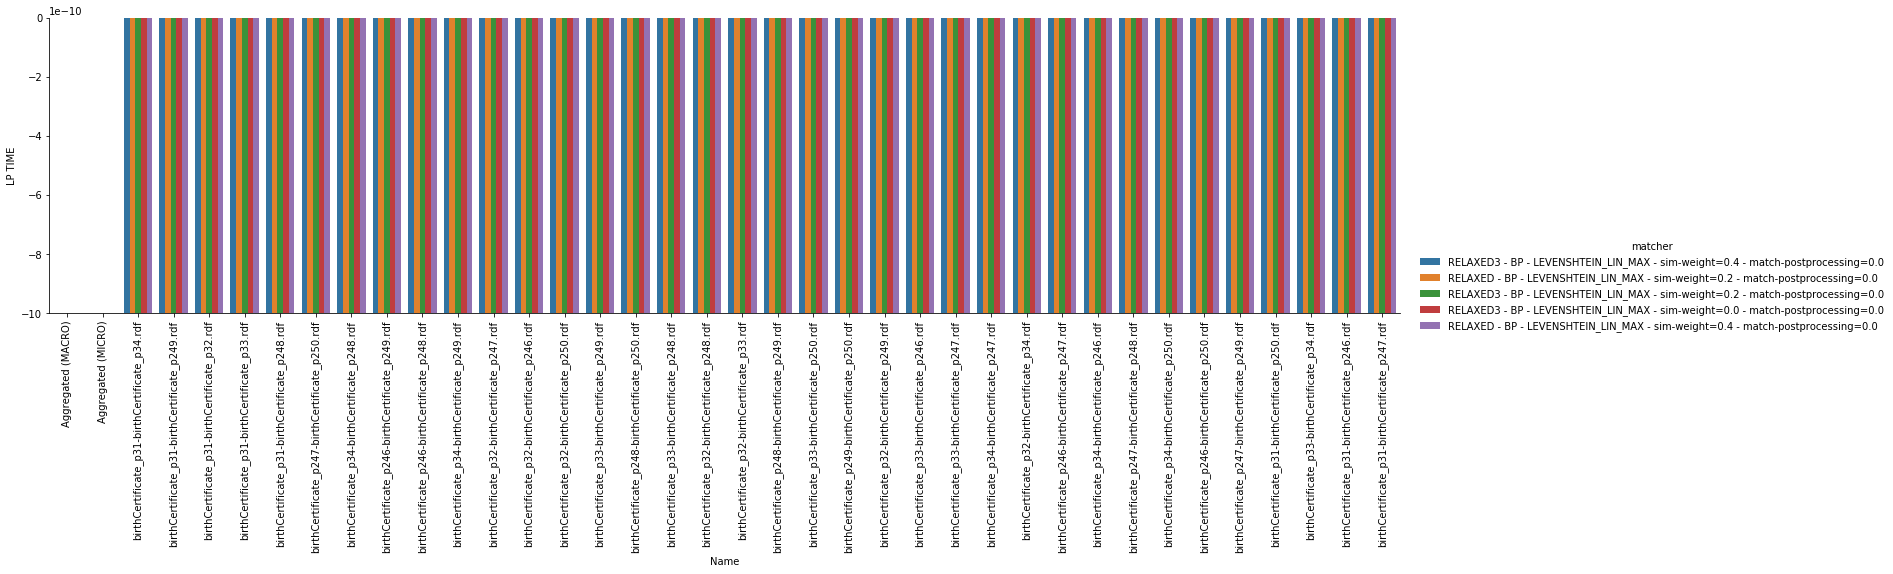

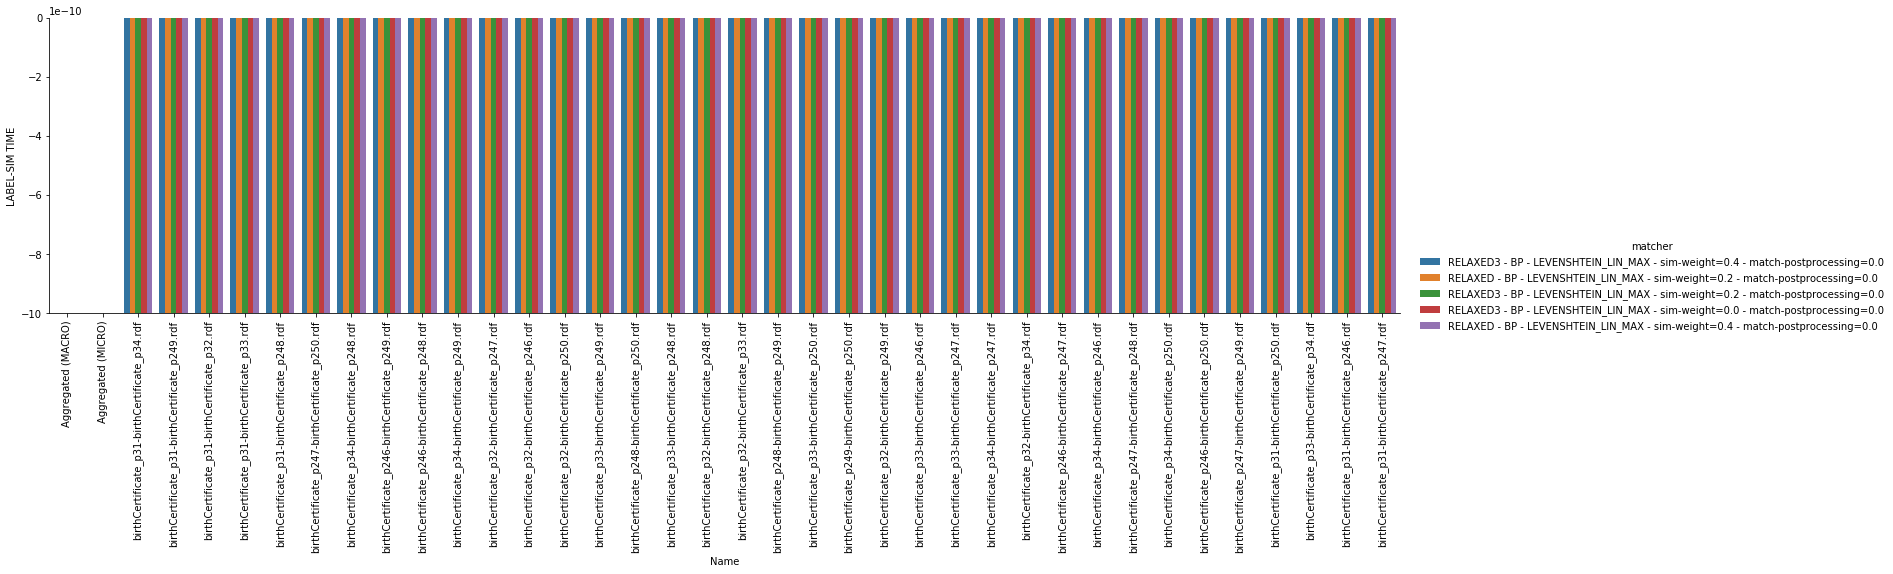

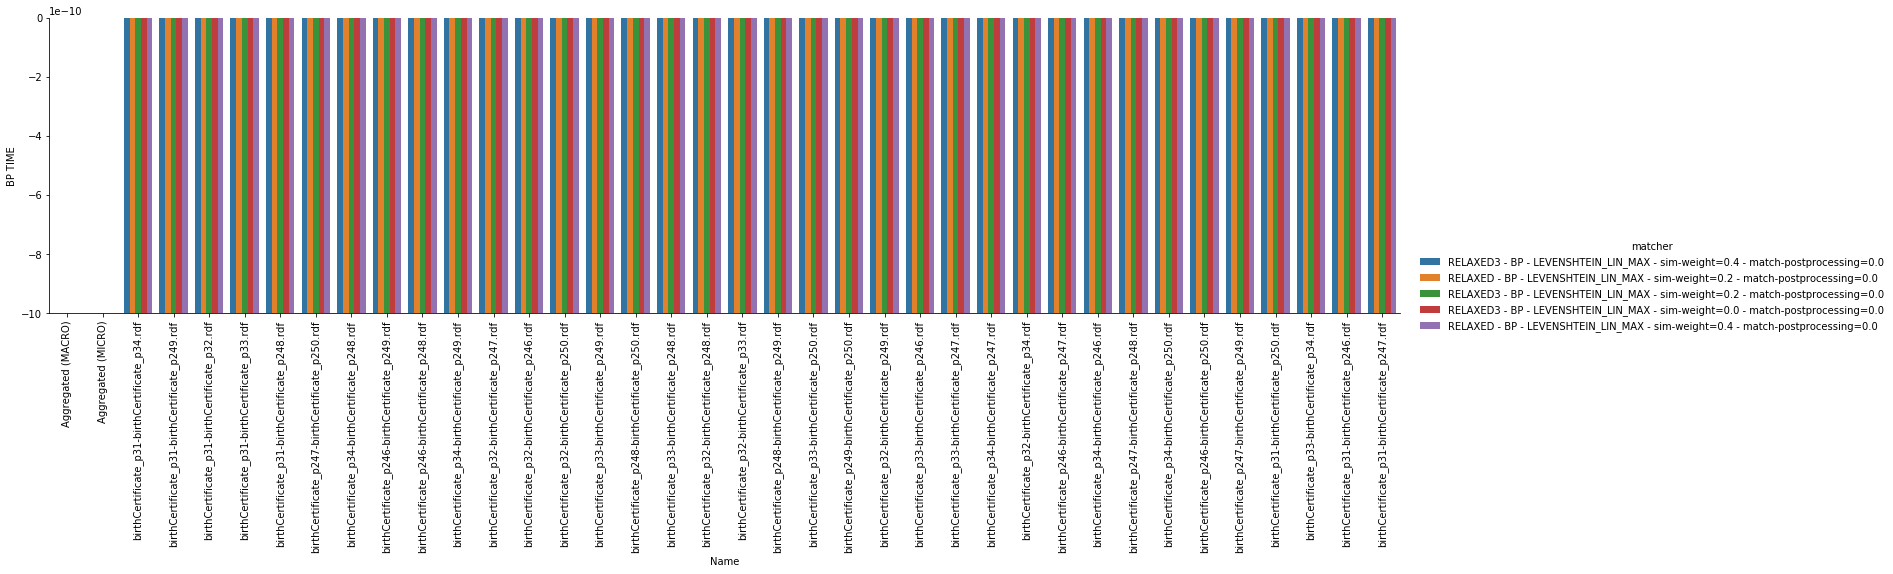

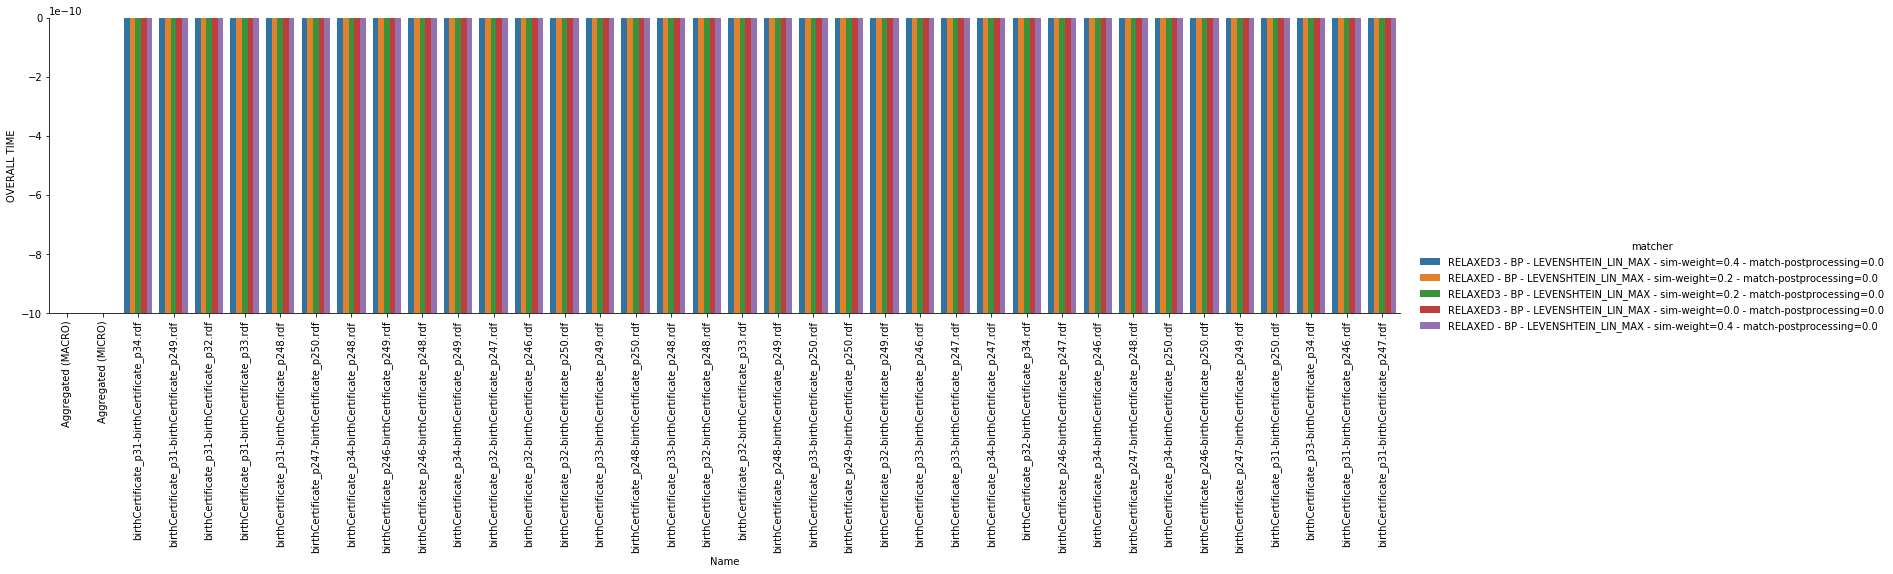

In [60]:
#BASIC VISUALIZATION

# visualize Precision 
g = sns.catplot(x="Name", y="PRECISION", hue="matcher", kind="bar", data=df_combined,  height=5, aspect=4);
g.set_xticklabels(rotation=90)

# Visualize Recall
g = sns.catplot(x="Name", y="RECALL", hue="matcher", kind="bar", data=df_combined,  height=5, aspect=4);
g.set_xticklabels(rotation=90)

# Visualize FSCORE
g = sns.catplot(x="Name", y="FSCORE", hue="matcher", kind="bar", data=df_combined,  height=5, aspect=4);
g.set_xticklabels(rotation=90)

#Visualize Runtime
g = sns.catplot(x="Name", y="LP TIME", hue="matcher", kind="bar", data=df_combined,  height=5, aspect=4);
g.set_xticklabels(rotation=90)

#Visualize Runtime
g = sns.catplot(x="Name", y="LABEL-SIM TIME", hue="matcher", kind="bar", data=df_combined,  height=5, aspect=4);
g.set_xticklabels(rotation=90)

#Visualize Runtime
g = sns.catplot(x="Name", y="BP TIME", hue="matcher", kind="bar", data=df_combined,  height=5, aspect=4);
g.set_xticklabels(rotation=90)

#Visualize Runtime
g = sns.catplot(x="Name", y="OVERALL TIME", hue="matcher", kind="bar", data=df_combined,  height=5, aspect=4);
g.set_xticklabels(rotation=90)



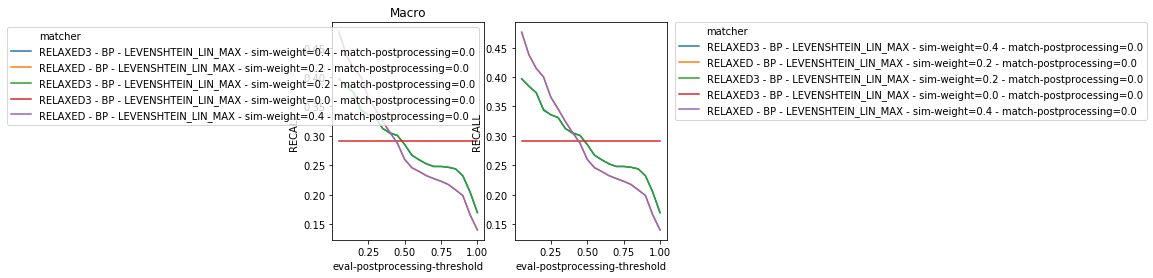

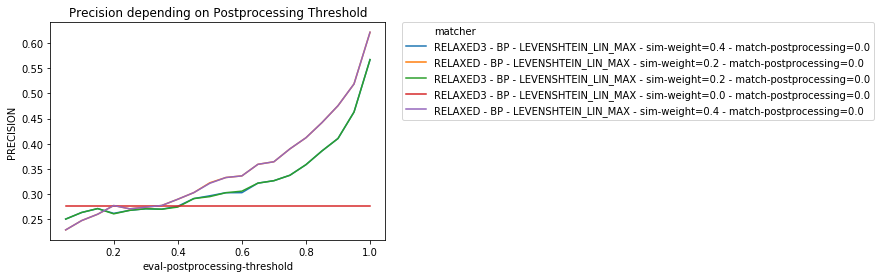

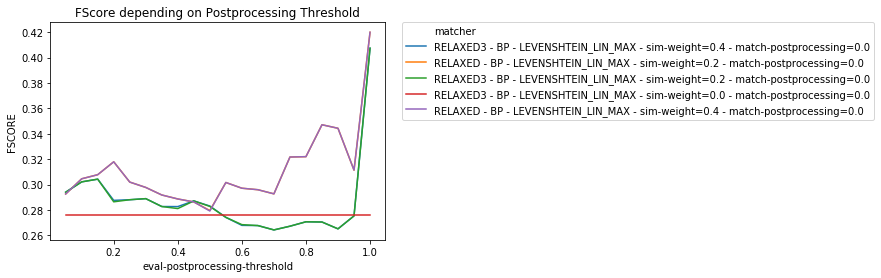

In [61]:
# Avg Precisision Recall Fscore over postprocessing threshold
df_macro_avg = df_combined[df_combined.Name == "Aggregated (MACRO)"]
df_micro_avg = df_combined[df_combined.Name == "Aggregated (MICRO)"]

fig, (ax1, ax2) = plt.subplots(1,2)
sns.lineplot(x="eval-postprocessing-threshold", y="RECALL", hue="matcher", data=df_macro_avg, ax = ax1);
ax1.set_title("Macro")
sns.lineplot(x="eval-postprocessing-threshold", y="RECALL", hue="matcher", data=df_macro_avg, ax = ax2);
ax1.set_title("Macro")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()
sns.lineplot(x="eval-postprocessing-threshold", y="PRECISION", hue="matcher", data=df_macro_avg);
plt.title("Precision depending on Postprocessing Threshold")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()
sns.lineplot(x="eval-postprocessing-threshold", y="FSCORE", hue="matcher", data=df_macro_avg);
plt.title("FScore depending on Postprocessing Threshold")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

/Users/dominikhuser/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
/Users/dominikhuser/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


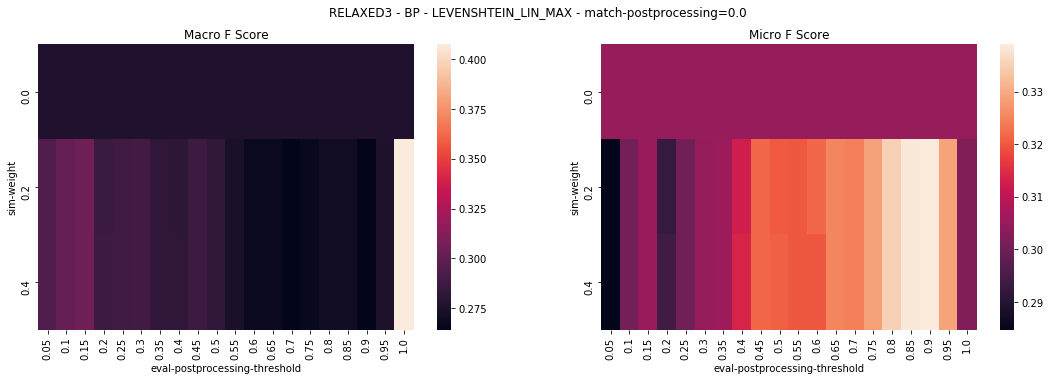

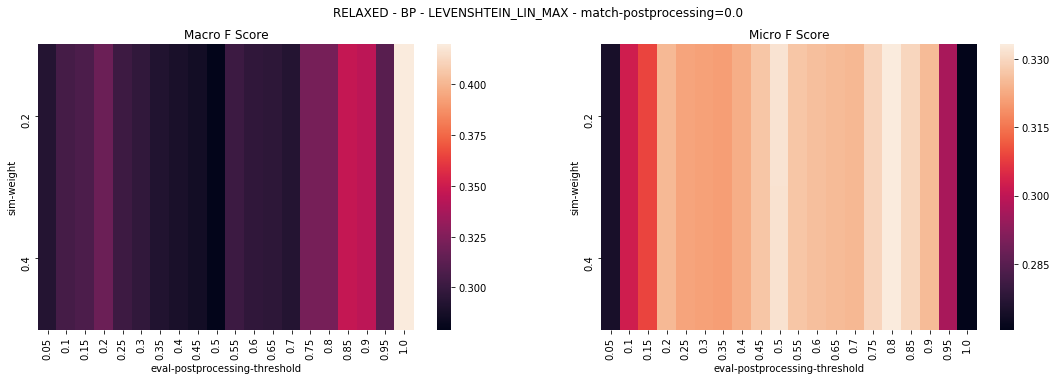

In [84]:
#avg fscore for each matcher depending on A) the sim weight B) the 
df_macro_avg = df_combined[df_combined.Name == "Aggregated (MACRO)"]
df_micro_avg = df_combined[df_combined.Name == "Aggregated (MICRO)"]

matchers = set(df_macro_avg["matcher_wo_weight"].values)
for m in matchers:
    df_macro_avg_fscore = df_macro_avg[df_macro_avg["matcher_wo_weight"] == m].pivot("sim-weight", "eval-postprocessing-threshold", "FSCORE")
    df_micro_avg_fscore = df_micro_avg[df_micro_avg["matcher_wo_weight"] == m].pivot("sim-weight", "eval-postprocessing-threshold", "FSCORE")
    
    fig, (ax1, ax2) = plt.subplots(1,2)
    fig.set_size_inches(18.5, 5.25)

    sns.heatmap(df_macro_avg_fscore, ax = ax1)
    ax1.set_title("Macro F Score")
    sns.heatmap(df_micro_avg_fscore, ax = ax2)
    ax2.set_title("Micro F Score")
    fig.suptitle(m)
    fig.show()


No handles with labels found to put in legend.


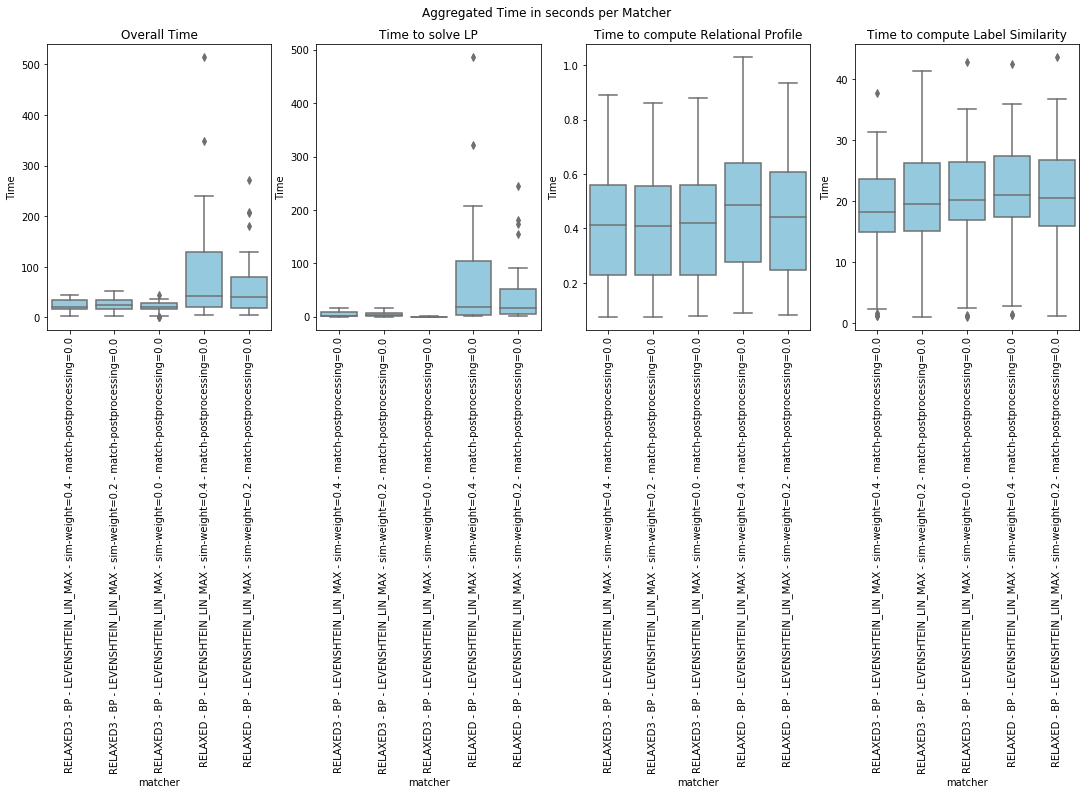

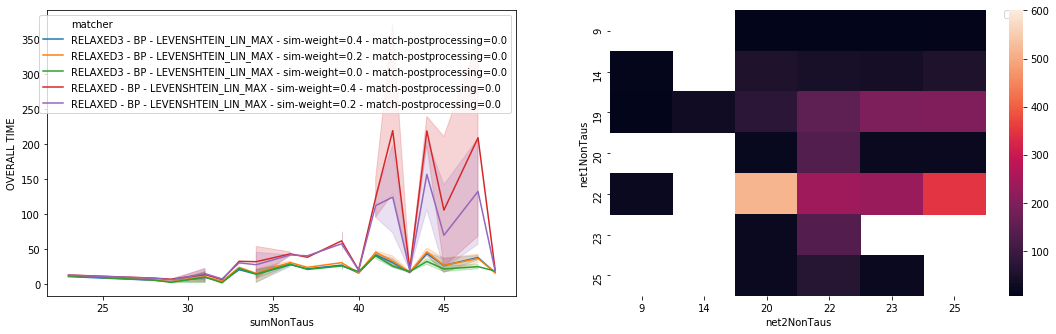

In [106]:
#runtime analysis
df_ = df_combined[df_combined["Name"] != "Aggregated (MICRO)"]
df_ = df_[df_["Name"] != "Aggregated (MACRO)"]

#boxplots for each matcher
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4)
fig.set_size_inches(18.5, 5.25)
sns.boxplot(x="matcher", y="OVERALL TIME", data=df_, ax=ax1, color='skyblue')
ax1.set_xticklabels(ax1.get_xticklabels(),rotation=90)
ax1.set_title("Overall Time")
ax1.set_ylabel("Time")
sns.boxplot(x="matcher", y="LP TIME", data=df_, ax=ax2, color='skyblue')
ax2.set_xticklabels(ax2.get_xticklabels(),rotation=90)
ax2.set_title("Time to solve LP")
ax2.set_ylabel("Time")
sns.boxplot(x="matcher", y="BP TIME", data=df_, ax=ax3, color='skyblue')
ax3.set_xticklabels(ax3.get_xticklabels(),rotation=90)
ax3.set_title("Time to compute Relational Profile")
ax3.set_ylabel("Time")
sns.boxplot(x="matcher", y="LABEL-SIM TIME", data=df_, ax=ax4, color='skyblue')
ax4.set_xticklabels(ax4.get_xticklabels(),rotation=90)
ax4.set_title("Time to compute Label Similarity")
ax4.set_ylabel("Time")
fig.suptitle("Aggregated Time in seconds per Matcher")

fig, (ax1,ax2) = plt.subplots(1,2)
fig.set_size_inches(18.5, 5.25)

# sum of tau transitions analysis
sns.lineplot(x="sumNonTaus", y="OVERALL TIME", hue="matcher", data=df_, ax=ax1);
plt.title("")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


#df_pivot = df_[['net1NonTaus', 'net2NonTaus','OVERALL TIME']].groupby(['net1NonTaus', 'net2NonTaus'])['OVERALL TIME'].transform(np.mean).to_frame()
df_pivot = pd.pivot_table(df_, values='OVERALL TIME', index=['net1NonTaus'], columns=['net2NonTaus'],aggfunc=np.max)
sns.heatmap(df_pivot, ax = ax2, vmax=600)

